The calculation is based on the following code, firstly, we import data from the database, and conduct EDA to check the correlation of given predictors.

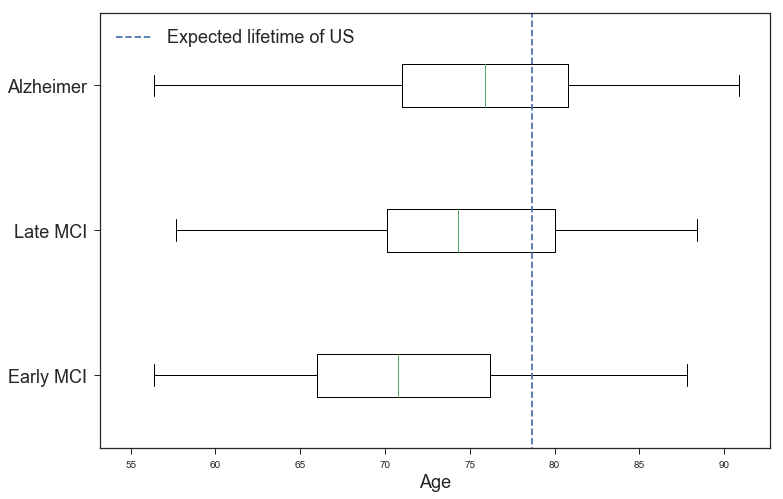

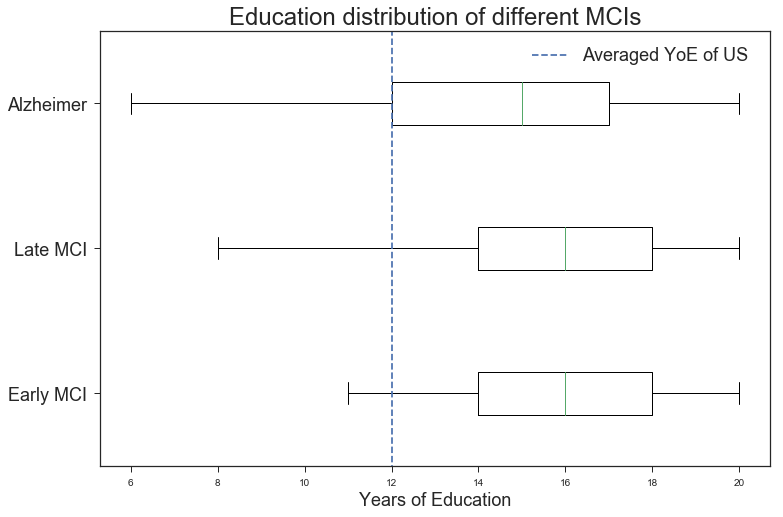

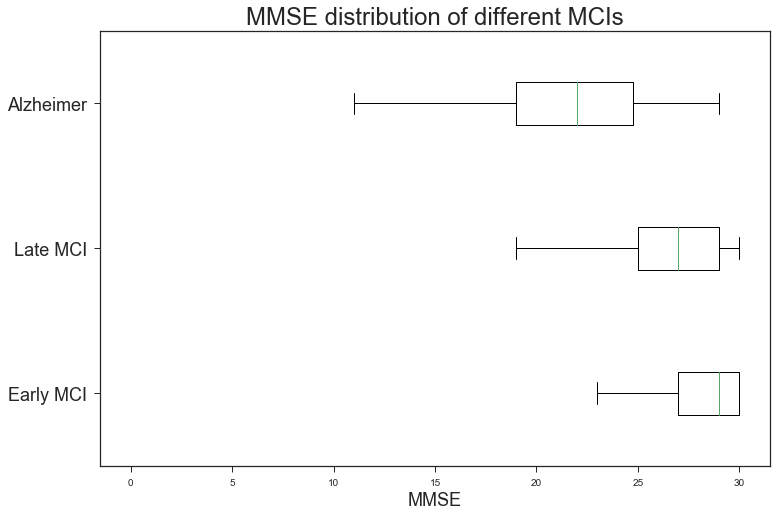

In [167]:
import pandas as pd
import sys
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tools import add_constant
from statsmodels.regression.linear_model import RegressionResults
import seaborn as sns
import sklearn as sk
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn import ensemble
import warnings
warnings.filterwarnings('ignore')
sns.set(style="ticks")
%matplotlib inline

# Read data
np.random.seed(9001)
df_train = pd.read_csv('ADNI_Training_Q1_APOE_July22.2014.csv')
df_train.head()

#Plot Age
fig=plt.figure(1,figsize=(12, 8) )
ax = fig.add_subplot(111)
data=[]
Age2=df_train.loc[df_train['DX.bl']=='EMCI','AGE'].values
Age3=df_train.loc[df_train['DX.bl']=='LMCI','AGE'].values
Age4=df_train.loc[df_train['DX.bl']=='AD','AGE'].values

data=[Age2,Age3,Age4]
plt.boxplot(data,'',vert=0)
ax.set_yticklabels(['Early MCI', 'Late MCI', 'Alzheimer'], fontsize=18)
ax.plot([78.7,78.7],[0,5],'--',label='Expected lifetime of US ')
plt.xlabel('Age', fontsize=18)
plt.legend( fontsize=18)

#Plot Years of education
fig=plt.figure(2,figsize=(12, 8) )
data=[]
Edu1=df_train.loc[df_train['DX.bl']=='EMCI','PTEDUCAT'].values
Edu2=df_train.loc[df_train['DX.bl']=='LMCI','PTEDUCAT'].values
Edu3=df_train.loc[df_train['DX.bl']=='AD','PTEDUCAT'].values

ax = fig.add_subplot(111)
data=[Edu1,Edu2,Edu3]
plt.boxplot(data,'',vert=0)
ax.set_yticklabels(['Early MCI', 'Late MCI', 'Alzheimer'], fontsize=18)
plt.xlabel('Years of Education', fontsize=18)
plt.legend( fontsize=18)
plt.title('Education distribution of different MCIs', fontsize=24)
plt.plot([12,12],[0,5],'--',label='Averaged YoE of US ')
plt.legend(fontsize=18)
ax = fig.add_subplot(111)

#Plot MMSE
fig=plt.figure(3,figsize=(12, 8) )
ax = fig.add_subplot(111)
data=[]
Edu1=df_train.loc[df_train['DX.bl']=='EMCI','MMSE'].values
Edu2=df_train.loc[df_train['DX.bl']=='LMCI','MMSE'].values
Edu3=df_train.loc[df_train['DX.bl']=='AD','MMSE'].values
data=[Edu1,Edu2,Edu3]
plt.boxplot(data,'',vert=0)
ax.set_yticklabels(['Early MCI', 'Late MCI', 'Alzheimer'], fontsize=18)
plt.xlabel('MMSE', fontsize=18)
plt.legend( fontsize=18)
plt.title('MMSE distribution of different MCIs', fontsize=24)


We take a look at the APOE4 predictor

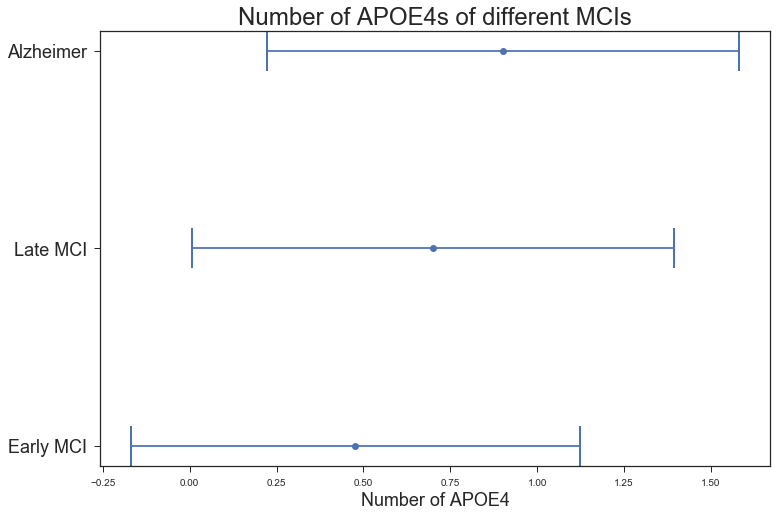

In [156]:
fig=plt.figure(1,figsize=(12, 8) )
ax = fig.add_subplot(111)
data=[]
Edu1=df_train.loc[df_train['DX.bl']=='EMCI','APOE4'].values
Edu2=df_train.loc[df_train['DX.bl']=='LMCI','APOE4'].values
Edu3=df_train.loc[df_train['DX.bl']=='AD','APOE4'].values

data=[Edu1.mean(),Edu2.mean(),Edu3.mean()]
Err=[Edu1.std(),Edu2.std(),Edu3.std()]
ax.errorbar(data,[0,1,2], xerr=Err, fmt='o',capsize=20,capthick=2)
ax.set_yticklabels(['Early MCI', 'Late MCI', 'Alzheimer'], fontsize=18)
ax.set_yticks([0,1,2])
plt.xlabel('Number of APOE4', fontsize=18)
plt.legend( fontsize=18)
plt.title('Number of APOE4s of different MCIs', fontsize=24)


APOE4 is the most well-known mutation related to AD. This mutation is directly linked with Alzheimer. Those with this mutation has significant higher chance of having AD.

In this study, we start with a benchmark model with elementary clinical information. Then we will try to improve it in two ways, firstly we try to use SVM method to boost the performance. Secondly we try to add gene data into the model.

In [157]:
import pandas as pd
import sys
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn import tree
from sklearn import ensemble
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
sns.set(style="ticks")
%matplotlib inline
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Each patient visit the hospital twice, only the first visit result is kept as we are intereted in long term prediction. And the development of MRI is going to be influenced by medication after the first visit. So second visits data are aborted

In [158]:
#Convert catagoritic predictors into numbers
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn import discriminant_analysis
from sklearn import preprocessing

firstvisit=np.arange(0,df_train.shape[0],2)
x=df_train.iloc[firstvisit,5:-2].copy()
y=df_train.iloc[firstvisit,4].copy()
x['PTGENDER'][x['PTGENDER']=='Male'  ]=0
x['PTGENDER'][x['PTGENDER']=='Female']=1
y[y=='CN']=0
y[y=='EMCI']=1
y[y=='LMCI']=2
y[y=='AD'  ]=3


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

np.random.seed(9001)
itrain, itest = train_test_split(range(x.shape[0]), train_size=0.75)
set1={}
set1['Xtrain'] = x.iloc[itrain].values
set1['Xtest'] = x.iloc[itest].values
set1['ytrain'] = y.iloc[itrain].values
set1['ytest'] = y.iloc[itest].values

We use kNN method as benchmark. The best number of neibourhood is determined via cross validation.

BEST PARAMS {'n_neighbors': 14}
Score on training data knn: 0.48174
Score on test data knn:     0.39062
Confusion matrix, without normalization
[[39  3 23  3]
 [ 7  9 15  2]
 [23 13 23  4]
 [ 8  2 14  4]]


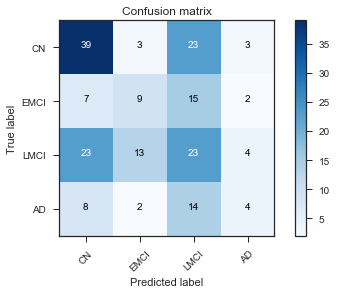

In [164]:
nfolds=10

knn = KNN()
gs_knn = GridSearchCV(knn, param_grid={'n_neighbors': np.arange(2,25,2)}, cv=nfolds)
gs_knn.fit(set1['Xtrain'],list(set1['ytrain']))
print("BEST PARAMS", gs_knn.best_params_)
training_score = gs_knn.score(set1['Xtrain'],list(set1['ytrain']))
test_score = gs_knn.score(set1['Xtest'], list(set1['ytest']))
print("Score on training data knn: %0.5f" % training_score)
print("Score on test data knn:     %0.5f" % test_score)

from sklearn.metrics import confusion_matrix
a=confusion_matrix(list(set1['ytest']), gs_knn.predict(set1['Xtest']))
plot_confusion_matrix(a,['CN','EMCI','LMCI','AD'])

Here we can see that the accuracy is 39%.
Next we try to look into SVM method, as this method can deal with multiple predictors and nonlinear classification.

BEST PARAMS {'C': 1000}
Score on training data knn: 0.42957
Score on test data knn:     0.45833
Confusion matrix, without normalization
[[43  0 24  1]
 [13  2 16  2]
 [18  4 37  4]
 [ 4  0 18  6]]


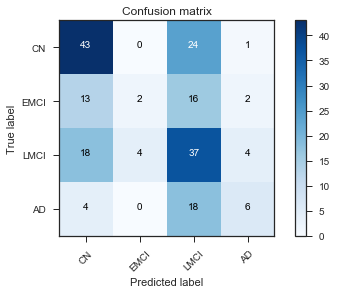

In [168]:
parameters = { 'C':[1, 10 ,100, 1000, 10000]}
nfolds=5

svc = svm.SVC(kernel='linear')
clf = GridSearchCV(svc, parameters, cv=nfolds)
clf.fit(set1['Xtrain'],list(set1['ytrain']))

print("BEST PARAMS", clf.best_params_)
training_score = clf.score(set1['Xtrain'],list(set1['ytrain']))
test_score = clf.score(set1['Xtest'], list(set1['ytest']))
print("Score on training data knn: %0.5f" % training_score)
print("Score on test data knn:     %0.5f" % test_score)

from sklearn.metrics import confusion_matrix
a=confusion_matrix(list(set1['ytest']), clf.predict(set1['Xtest']))
plot_confusion_matrix(a,['CN','EMCI','LMCI','AD'])

The accuracy is boosted to 45%, with C=1000 as regulator.

Then we try to add gene expression data into the model, the predictors are found in the papers. 

In [184]:
df = pd.read_csv('ADNI_Gene_Expression_Profile.csv', header=2, low_memory=False)
A=df.loc[df['Unnamed: 2'].isin(['ABCA7','MS4A6A','MS4A4E','EPHA1','CD33','CD2AP','MS4A4','MS4A6E'])].copy()
del(df)
B=A.iloc[:,3:-1].transpose()
B.columns=A.iloc[:,2]
name=A.columns.values[3:-1]
B['name']=name

We use random forest method to evaluate the quality of the predictors. Half of the predictors are aborted with 300 repitations. The result is summarized below.

/Users/sijie/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


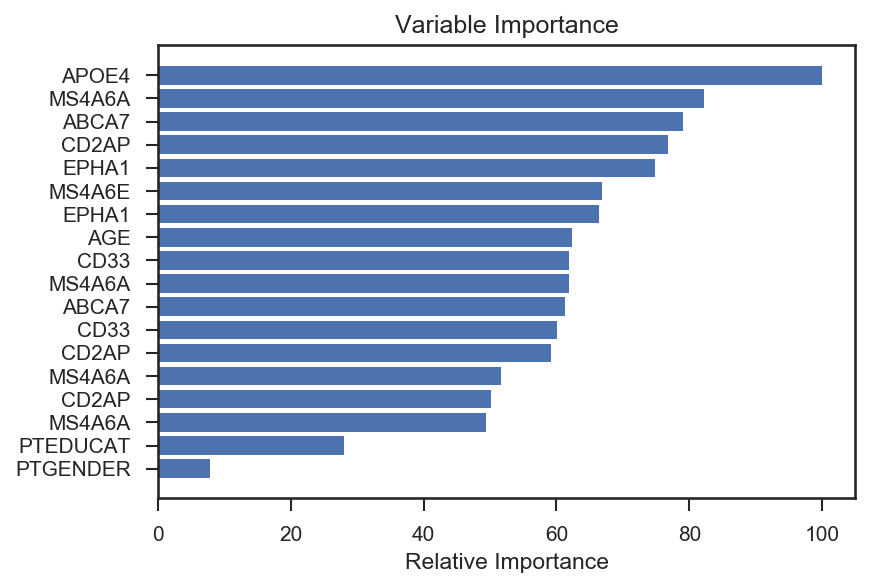

In [107]:
#Align Gene data to the clinical data
New=x.merge(B, left_on='name', right_on='name', how='left')
New['diagnosis']=y
New.drop(['name'], axis=1, inplace=True)
Clean=New.dropna(axis=0, how='any')#Eliminate the NaNs
itrain, itest = train_test_split(range(Clean.shape[0]), train_size=0.75)
set2={}
set2['Xtrain'] = Clean.iloc[itrain,0:-1].values
set2['Xtest'] = Clean.iloc[itest,0:-1].values
set2['ytrain'] = Clean.iloc[itrain,-1].values
set2['ytest'] = Clean.iloc[itest,-1].values

rf = ensemble.RandomForestClassifier( n_estimators=300, oob_score=True,max_features=8)
rf.fit(set2['Xtrain'] , list(set2['ytrain']))

feature_importance = rf.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())

sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.rcParams['figure.dpi'] = 150
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, Clean.iloc[itrain,0:-1] .columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')


In [110]:
# SVM method with more predictors
parameters = { 'C':[1, 10 ,100, 1000, 10000]}
nfolds=5

svc = svm.SVC(kernel='linear')
clf = GridSearchCV(svc, parameters, cv=nfolds)
clf.fit(set2['Xtrain'],list(set2['ytrain']))

print("BEST PARAMS", clf.best_params_)
training_score = clf.score(set2['Xtrain'],list(set2['ytrain']))
test_score = clf.score(set2['Xtest'], list(set2['ytest']))
print("Score on training data SVM: %0.5f" % training_score)
print("Score on test data SVM:     %0.5f" % test_score)

confusion_matrix(list(set2['ytest']), clf.predict(set2['Xtest']))


BEST PARAMS {'C': 1}
Score on training data SVM: 0.57317
Score on test data SVM:     0.45455


array([[17,  5,  7,  0],
       [ 3,  3,  0,  0],
       [ 7,  3,  5,  0],
       [ 4,  0,  1,  0]])

In [105]:
#Random forest with 200 trees and increased number of predictors
rf = ensemble.RandomForestClassifier(n_estimators=200)
rf.fit(set2['Xtrain'],list(set2['ytrain']))
training_score = rf.score(set2['Xtrain'],list(set2['ytrain']))
test_score     = rf.score(set2['Xtest'], list(set2['ytest']))
print("Score on training data RF: %0.5f" % training_score)
print("Score on test data RF:     %0.5f" % test_score)
confusion_matrix(list(set2['ytest']), rf.predict(set2['Xtest']))


Score on training data RF: 1.00000
Score on test data RF:     0.40000


array([[14,  3,  6,  0],
       [ 6,  2,  2,  0],
       [ 8,  1,  6,  0],
       [ 5,  0,  2,  0]])

In [183]:
#LDA and QDA are also adapted for recreation
lda = discriminant_analysis.LinearDiscriminantAnalysis()
lda.fit(set2['Xtrain'],list(set2['ytrain']))
training_score = lda.score(set2['Xtrain'],list(set2['ytrain']))
test_score = lda.score(set2['Xtest'], list(set2['ytest']))
print("Score on training data: %0.5f, lda" % training_score)
print("Score on test data:     %0.5f, lda" % test_score)


qda = discriminant_analysis.QuadraticDiscriminantAnalysis()
qda.fit(set2['Xtrain'],list(set2['ytrain']))
training_score = qda.score(set2['Xtrain'],list(set2['ytrain']))
test_score = qda.score(set2['Xtest'], list(set2['ytest']))
print("Score on training data: %0.5f, qda" % training_score)
print("Score on test data:     %0.5f, qda" % test_score)
confusion_matrix(list(set2['ytest']), qda.predict(set2['Xtest']))


Score on training data: 0.56707, lda
Score on test data:     0.47273, lda
Score on training data: 0.89634, qda
Score on test data:     0.29091, qda


array([[ 1,  0, 28,  0],
       [ 0,  0,  6,  0],
       [ 0,  0, 15,  0],
       [ 0,  0,  5,  0]])

Here we can see that the additional predictors has high quality. But they does not yield better performance, as we only have less than 200 samples left as training sample, the overfitting is severe. Here we adapt PCA to decrease the number of predictors to prevent overfitting

In [179]:
x0=set2['Xtrain'].astype('float32')
x1=set2['Xtest'].astype('float32')

from sklearn.decomposition import PCA
#Normorlization
for i in range(x0.shape[1]):
    Mean=x0[:,i].mean()
    std=x0[:,i].std()
    if std ==0:
        std=1
    x0[:,i]=(x0[:,i]-Mean)/std
    x1[:,i]=(x1[:,i]-Mean)/std
pca = PCA(n_components=8)
pca.fit(x0)
x0_pca = pca.transform(x0)
x1_pca = pca.transform(x1)
print('Explained variance ratio:', pca.explained_variance_ratio_)

Explained variance ratio: [ 0.23052159  0.13512515  0.08727197  0.07294347  0.06260256  0.05437085
  0.05072539  0.04785819]


Then we use random forest to predict based on lumped predictor set.

In [180]:
rf = ensemble.RandomForestClassifier(n_estimators=200)
rf.fit(x0_pca,list(set2['ytrain']))
training_score = rf.score(x0_pca,list(set2['ytrain']))
test_score     = rf.score(x1_pca, list(set2['ytest']))
print("Score on training data RF: %0.5f" % training_score)
print("Score on test data RF:     %0.5f" % test_score)
confusion_matrix(list(set2['ytest']), rf.predict(x1_pca))


Score on training data RF: 1.00000
Score on test data RF:     0.58182


array([[23,  0,  6,  0],
       [ 3,  0,  3,  0],
       [ 6,  0,  9,  0],
       [ 2,  0,  3,  0]])

The accuracy is boosted to 58%, which is sigficant higher than the previous data.

Confusion matrix, without normalization
[[23  0  6  0]
 [ 3  0  3  0]
 [ 6  0  9  0]
 [ 2  0  3  0]]


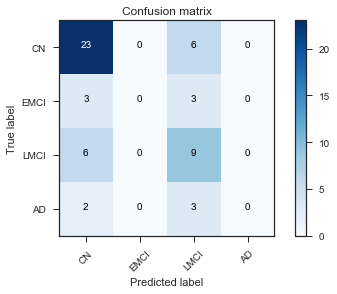

In [181]:
a=confusion_matrix(list(set2['ytest']), rf.predict(x1_pca))
plot_confusion_matrix(a,['CN','EMCI','LMCI','AD'])